#Preliminary operations

##Import libraries

In [1]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler
# train, test, split
from sklearn.model_selection import train_test_split
# decision tree classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
# repeated stratified kfold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
# randomized and grid search cv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Dummy clf
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

##Mount Google Drive

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [4]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Regression/Classification retest/Data prepared/df_prep_final.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Regression/Classification retest/Data prepared/df_prep_final_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Regression/Classification retest/Data prepared/df_prep_final_emph_low.xlsx", index_col="Unnamed: 0")

In [5]:
df.columns

Index(['vocal_channel', 'emotion', 'emotional_intensity', 'statement',
       'repetition', 'actor', 'sex', 'channels', 'length_ms', 'intensity',
       'zero_crossings_sum', 'mfcc_mean', 'mfcc_max', 'sc_mean', 'sc_std',
       'sc_min', 'sc_max', 'sc_kur', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'mean', 'kur', 'skew', 'loudness', 'emotion_type'],
      dtype='object')

In [6]:
# get data columns
df_data = df.loc[:, "length_ms":"skew"]
df_data_emph_high = df_emph_high.loc[:, "length_ms":"skew"]
df_data_emph_low = df_emph_low.loc[:, "length_ms":"skew"]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

COSE DA FARE PER LA CLASSIFICAZIONE (PER OGNI MODELLO):

Le cose che facciamo le facciamo per tutti e 3 i dataset (all emphasis, high emphasis e low emphasis). Facciamo la classificazione per le due variabili che abbiamo usato anche nel Clustering: "emotions" e "emotional_type" (strong, weak).

* Dividere in "training_set" (80%) e "test_set" (20%)
* Usare il "training_set" per fare la Cross_Validation stratificata (Stratified Cross Validation) in 10 parti per testare gli iperparametri, con Grid-Search se non va troppo lento; se va lento usiamo Randomized-Search.
* Testare la classificazione su tutte e due le variabili dette prima, per ognuno dei 3 dataset che abbiamo
* Misuarci tutte le metriche possibili e immaginabili che ha fatto vedere lo Spinnnato in laboratorio
* Fine, basta, boh. Bona cisi e se un cisi bona

#Emotions

##Decision Tree

In [7]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

In [8]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.1425661914460285


In [9]:
# optimized Decision Tree DT
DT = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 18, 
    min_samples_split = 3,
    class_weight="balanced",
    random_state=0
)

DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.42      0.43      0.42        75
        calm       0.47      0.52      0.49        75
     disgust       0.27      0.31      0.29        39
     fearful       0.32      0.28      0.30        75
       happy       0.32      0.31      0.31        75
     neutral       0.27      0.26      0.27        38
         sad       0.26      0.27      0.26        75
   surprised       0.30      0.26      0.28        39

    accuracy                           0.34       491
   macro avg       0.33      0.33      0.33       491
weighted avg       0.34      0.34      0.34       491



In [11]:
y_test_pred_proba = DT.predict_proba(X_test)
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.6180276349326479


##KNN

In [12]:
clf = KNeighborsClassifier(n_neighbors=3, metric="cityblock", weights="distance")

In [13]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [14]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.1425661914460285


In [15]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.51      0.52      0.52        75
        calm       0.60      0.57      0.59        75
     disgust       0.38      0.36      0.37        39
     fearful       0.49      0.35      0.41        75
       happy       0.32      0.37      0.35        75
     neutral       0.31      0.39      0.35        38
         sad       0.48      0.41      0.44        75
   surprised       0.45      0.62      0.52        39

    accuracy                           0.45       491
   macro avg       0.44      0.45      0.44       491
weighted avg       0.46      0.45      0.45       491



In [17]:
y_test_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.7782544365422935


##Naive Bayes

In [18]:
clf = GaussianNB(
    var_smoothing=5.366976945540476e-15
)

In [19]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emotion,
    test_size=0.2, 
    random_state=0,
    stratify=y_emotion
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [20]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.1425661914460285


In [21]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.48      0.67      0.56        75
        calm       0.47      0.43      0.45        75
     disgust       0.26      0.26      0.26        39
     fearful       0.39      0.17      0.24        75
       happy       0.24      0.27      0.25        75
     neutral       0.16      0.16      0.16        38
         sad       0.28      0.12      0.17        75
   surprised       0.24      0.59      0.35        39

    accuracy                           0.33       491
   macro avg       0.32      0.33      0.30       491
weighted avg       0.34      0.33      0.31       491



In [23]:
y_test_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.7642961707513349


#Emotion type

##Decision tree

In [24]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

In [25]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


In [26]:
# optimized Decision Tree DT
DT = DecisionTreeClassifier(
    criterion = 'entropy',
    max_depth = 18, 
    min_samples_split = 3,
    class_weight="balanced",
    random_state=0
)

DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.84      0.82      0.83       303
        weak       0.72      0.75      0.73       188

    accuracy                           0.79       491
   macro avg       0.78      0.78      0.78       491
weighted avg       0.79      0.79      0.79       491



In [28]:
y_test_pred_proba = DT.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.7849957868127239


##KNN

In [29]:
clf = KNeighborsClassifier(n_neighbors=3, metric="cityblock", weights="distance")

In [30]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [31]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


In [32]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.83      0.86      0.85       303
        weak       0.76      0.72      0.74       188

    accuracy                           0.81       491
   macro avg       0.80      0.79      0.79       491
weighted avg       0.81      0.81      0.81       491



In [34]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.8957762797556351


##Naive Bayes

In [35]:
clf = GaussianNB(
    var_smoothing=5.366976945540476e-15
)

In [36]:
# split train- and test- set
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_emtype,
    test_size=0.2, 
    random_state=0,
    stratify=y_emtype
)

# standardizing the new training set and the test set
std_sclr = StandardScaler()
std_sclr.fit(X_train)
X_train = std_sclr.transform(X_train)
X_test = std_sclr.transform(X_test)

In [37]:
# get two baseline (for validation- and for test- set)
dummy_clf = DummyClassifier(strategy="stratified", random_state=0)
dummy_clf.fit(X_train, y_train)

print(dummy_clf.score(X_test, y_test))

0.4969450101832994


In [38]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      strong       0.82      0.78      0.80       303
        weak       0.67      0.73      0.70       188

    accuracy                           0.76       491
   macro avg       0.75      0.76      0.75       491
weighted avg       0.77      0.76      0.76       491



In [40]:
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_test_pred_proba, multi_class="ovr", average="macro"))

0.8208166561336986


# Comparison

In [66]:
classifiers = ["Decision-Tree", "KNN", "Naive Bayes"]
datasets = ["without regression", "with regression"]

accuracies_emotion = [[33, 34],
                      [42, 45],
                      [30, 33]]
                      
emotion_res = np.array(
    [["Decision-Tree", "without regression", 33],
     ["Decision-Tree", "with regression", 34],
     ["KNN", "without regression", 42],
     ["KNN", "with regression", 45],
     ["Naive Bayes", "without regression", 30],
     ["Naive Bayes", "with regression", 33]
     ]
)

emotion_res_df = pd.DataFrame(emotion_res, columns=["model", "filling_method", "Accuracy"])
emotion_res_df["Accuracy"] = emotion_res_df["Accuracy"].astype(int)

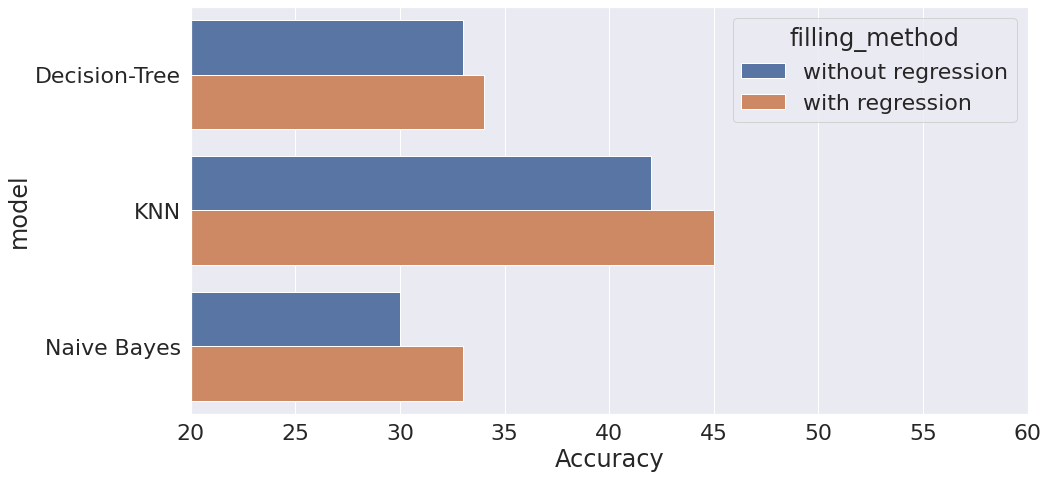

In [86]:
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2)
sns.barplot(data=emotion_res_df, x="Accuracy", y="model", hue="filling_method", orient="h")
plt.xlim(20, 60)
plt.savefig("regression_emotion.svg", format="svg")
plt.show()

In [73]:
emtype_res = np.array(
    [["Decision-Tree", "without regression", 76],
     ["Decision-Tree", "with regression", 79],
     ["KNN", "without regression", 81],
     ["KNN", "with regression", 81],
     ["Naive Bayes", "without regression", 75],
     ["Naive Bayes", "with regression", 76]
     ]
)

emtype_res_df = pd.DataFrame(emtype_res, columns=["model", "filling_method", "Accuracy"])
emtype_res_df["Accuracy"] = emtype_res_df["Accuracy"].astype(int)

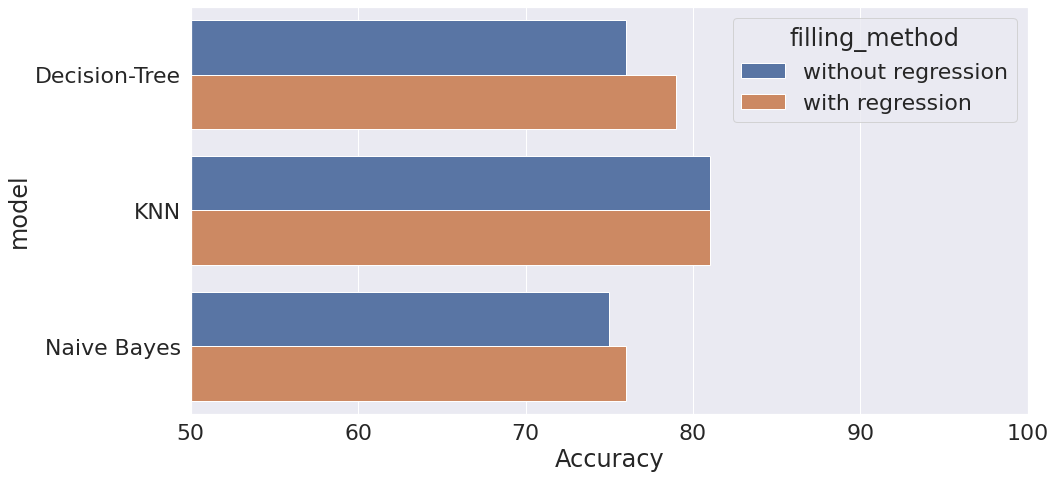

In [85]:
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2)
sns.barplot(data=emtype_res_df, x="Accuracy", y="model", hue="filling_method", orient="h")
plt.xlim(50, 100)
plt.savefig("regression_emtype.svg", format="svg")
plt.show()